# Selecting model points by cluster analysis - cashflow replication

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lifelib-dev/clustering-model-points/HEAD?labpath=cluster_model_points.ipynb)


<div class="alert alert-block alert-danger"> The final version of this notebook is merged into lifelib. Find it <a href="https://lifelib.io/libraries/notebooks/cluster/cluster_model_points.html">here</a>.
</div>


This notebook tries to apply cluster analysis techniques to model point selection.

We use the k-means method to partition a sample portfolio of seriatim term policies and select representative model points that best reprecate the net cashflows of the clusters.

For this exercise, 10,000 sample seriatim term policies and their base net annual cashflows are generated by BasicTerm_ME in the lifelib's basliclife library. 

The seriatim model points are partitioned into 1,000 clusters using the k-means method. For this exercise, policies are expressed as vectors of annual cashflows, as poposed by Goto. This approach is somewhat unique and exiotic, as other studies use policy attributes as well as some calculated quantities for the vector elements.

In each cluster, the policy closest to the cluster center is chosen as the representative model point of the cluster.
The cashflows of the representative model points are multiplied by the numbers of model points in the clusters, and compared against the base cashflows.

The representative model points are also tested using two other stressed sets of cashflows.  

[Y.Goto. A method to determine model points with cluster analysis, *Virtual ICA 2018*](https://www.actuview.com/video/A-method-to-determine-model-points-with-cluster-analysis/9084a36ba)


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

The base seriatim cashflows are read from an Excel file into DataFrame `cfs`.

In [2]:
cfs = pd.read_excel('cashflows_seriatim_10K.xlsx', index_col=0)
cfs

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
policy_id,,,,,,,,,,,,,,,,,,,,,
1,454.929938,310.300392,190.402436,103.660852,60.242358,21.088041,-16.544396,-27.751069,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
2,-117.037364,-159.638386,-27.581242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
3,676.812950,428.804452,239.065037,144.628379,59.786543,-21.431505,-61.849044,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
4,38.419532,17.670184,-3.802256,-26.067321,-49.200605,-73.284343,-98.408043,-124.669193,-44.236933,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
5,79.846717,61.399261,45.036933,29.644374,14.071303,-1.979159,-18.549807,-35.687112,-31.501112,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,21.829035,-151.131485,-333.363260,-525.782600,-729.386065,-945.256305,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
9997,-57.354220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0
9998,129.457751,1.548025,-132.731547,-274.016351,-422.998834,-580.433319,-596.913587,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,0.0,0


In [3]:
claims = pd.read_excel('claims_seriatim_10K.xlsx', index_col=0)
claims

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
policy_id,,,,,,,,,,,,,,,,,,,,,
1,570.981624,636.969442,725.741867,804.238218,839.240377,876.962548,917.629234,628.341568,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
2,783.930485,811.903659,134.889547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
3,1099.848573,1258.292437,1413.378363,1482.761472,1557.645352,1638.501321,1273.240328,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
4,371.574020,383.173403,395.674293,409.141752,423.646933,439.267655,456.089029,474.204156,158.964805,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
5,351.100048,357.546308,364.593160,372.273436,380.623203,389.682032,399.493299,410.104517,277.370228,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2191.650855,2313.744606,2445.797369,2588.684224,2743.358925,2910.859559,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
9997,617.424386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
9998,1682.134606,1769.248397,1863.347928,1965.039659,2074.986255,2193.911286,1912.414712,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0


K-means clustering is performed by scikit-learn. The code below returns a `KMeans` object, which is fitted to `cfs`.

By default, the model point compression ratio(No. of seriatim policies / No. of representative model points) is set to 10 (= 10000 / 1000). To change the ration, change the number given to `n_clusters` below, and restart and run-all this notebook.

In [4]:
kmeans = KMeans(n_clusters=1000, random_state=0).fit(np.ascontiguousarray(cfs))
kmeans

KMeans(n_clusters=1000, random_state=0)

The centers of the clusters are cashflows and accessible as `cluster_centers_`.

In [5]:
kmeans.cluster_centers_.shape

(1000, 21)

We choose representative model points as the nearest to the centers by the `pairwise_distances_argmin_min` function offered by scikit-learn. 

Reference: https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn

In [6]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, np.ascontiguousarray(cfs))

Note that in the code above, `closest` contains the array indexes of the representative model points, which are 0-based indexes.
To use them as `policy_id` to be consistent with the index of the `cfs` DataFrame, 1 should be added.

In [7]:
rep_ids = pd.Series(data=(closest+1))   # 0-based to 1-based indexes
rep_ids.name = 'policy_id'
rep_ids = rep_ids.to_frame()
rep_ids.index.name = 'cluster_id'
rep_ids

,policy_id
cluster_id,
0,4345
1,2703
2,9019
3,7948
4,226
...,...
995,8220
996,3255
997,9928


The `labels_` attribute of `kmeans` returns an array of indexes indicating what cluster each seriatim model point belongs to. The indexes are used as `cluster_id`.

In [8]:
kmeans.labels_

array([399, 279, 153, ..., 699, 345,  47])

The code below extracts the cashflows of the representative model points from the original cashflow data, `cfs`. The extracted cashflows are in the order of `cluster_id`.

In [9]:
rep_cfs = pd.merge(rep_ids, cfs.reset_index(), how='left', on='policy_id')
rep_cfs.index.name = 'cluster_id'
rep_cfs

,policy_id,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,4345,338.847064,241.605165,165.813391,129.864504,99.482616,72.471808,46.991708,21.130781,-5.812657,...,-73.929847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,2703,43.301124,31.308844,20.425121,9.919457,-0.801858,-11.840055,-23.222074,-34.977185,-20.414954,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
2,9019,2137.066845,1674.065568,1295.802162,1076.743104,906.037863,762.292960,635.457932,512.979246,384.604135,...,-42.865375,-201.818002,-370.295328,-549.141734,-739.241445,-941.510677,-78.758286,0.000000,0.0,0
3,7948,-377.488343,-564.182307,-762.487163,-973.464305,-81.577460,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,226,1555.917819,1293.269964,1027.322728,748.412616,455.212012,146.285865,-179.913387,-525.049730,-890.905713,...,-1312.366877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8220,-232.078868,668.950192,479.898450,330.620029,206.534089,110.426248,60.308519,14.729196,-29.501292,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
996,3255,2091.272863,1633.012810,1275.918118,986.455215,807.890408,680.892878,575.087196,483.008141,396.458706,...,112.881775,8.421140,-101.848949,-218.495584,-342.129773,-473.407666,-613.030999,-160.403323,0.0,0
997,9928,164.186178,113.434413,61.421826,7.402393,-48.819632,-107.457385,-68.317943,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0


For each cluster, we need to obtain the number of seriatim policies belonging to the cluster, in order use it for scaling the cashflows of the cluster's representative model point.
We also want the aggregated seriatim cashflows for each cluster, so that we can compare the cashflows calculsted by the cluster's representative model point against them.

In [10]:
cfs_with_cluster_id = cfs.copy()
cfs_with_cluster_id.insert(0, 'policy_count', 1)
cfs_with_cluster_id.insert(0, 'cluster_id', kmeans.labels_)
cfs_with_cluster_id= cfs_with_cluster_id.set_index('cluster_id')
agg_cfs_by_cluster = cfs_with_cluster_id.groupby(cfs_with_cluster_id.index).agg(sum)
agg_cfs_by_cluster

,policy_count,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,16,5244.391964,3743.019549,2631.616881,1997.155379,1516.171341,1087.642371,681.727190,270.378024,-158.181614,...,-1093.642449,-259.701783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,81,3768.298778,2801.310674,1698.638078,713.992044,-135.884979,-831.018488,-1528.780035,-2099.181273,-1904.396571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
2,1,2137.066845,1674.065568,1295.802162,1076.743104,906.037863,762.292960,635.457932,512.979246,384.604135,...,-42.865375,-201.818002,-370.295328,-549.141734,-739.241445,-941.510677,-78.758286,0.000000,0.0,0
3,7,-2489.869320,-3897.602236,-5388.296692,-6759.703527,-427.159795,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,1,1555.917819,1293.269964,1027.322728,748.412616,455.212012,146.285865,-179.913387,-525.049730,-890.905713,...,-1312.366877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,-820.578703,1939.729687,1392.369449,961.434827,604.566894,325.549087,185.049816,58.000870,-64.522597,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
996,1,2091.272863,1633.012810,1275.918118,986.455215,807.890408,680.892878,575.087196,483.008141,396.458706,...,112.881775,8.421140,-101.848949,-218.495584,-342.129773,-473.407666,-613.030999,-160.403323,0.0,0
997,9,1482.628531,999.823697,503.215584,-13.165037,-551.254079,-1113.160325,-551.364249,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0


`mult_rep_cfs` below returns the cashflows of each cluster calculated as the cashflows of the representative model point multiplied by the number of policies in the cluster.

In [11]:
mult_rep_cfs = rep_cfs[rep_cfs.columns[1:]].mul(agg_cfs_by_cluster['policy_count'], axis=0)
mult_rep_cfs

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,5421.553018,3865.682645,2653.014254,2077.832064,1591.721851,1159.548925,751.867333,338.092493,-93.002515,-543.137796,...,-1182.877556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,3507.391081,2536.016369,1654.434793,803.475979,-64.950473,-959.044481,-1880.988002,-2833.151990,-1653.611312,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
2,2137.066845,1674.065568,1295.802162,1076.743104,906.037863,762.292960,635.457932,512.979246,384.604135,249.617315,...,-42.865375,-201.818002,-370.295328,-549.141734,-739.241445,-941.510677,-78.758286,0.000000,0.0,0
3,-2642.418398,-3949.276148,-5337.410139,-6814.250133,-571.042223,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,1555.917819,1293.269964,1027.322728,748.412616,455.212012,146.285865,-179.913387,-525.049730,-890.905713,-1279.382082,...,-1312.366877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-696.236603,2006.850577,1439.695349,991.860087,619.602266,331.278743,180.925558,44.187588,-88.503877,-141.852883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
996,2091.272863,1633.012810,1275.918118,986.455215,807.890408,680.892878,575.087196,483.008141,396.458706,306.434470,...,112.881775,8.421140,-101.848949,-218.495584,-342.129773,-473.407666,-613.030999,-160.403323,0.0,0
997,1477.675606,1020.909721,552.796437,66.621533,-439.376688,-967.116469,-614.861485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0


Below the total annual cashflows of the seriatim policies and the scaled model points are compared.

In [12]:
cf_comp = pd.DataFrame({'seriatim': agg_cfs_by_cluster.sum().iloc[1:], 'representative': mult_rep_cfs.sum()})
cf_comp['ratio'] = cf_comp['representative'] / cf_comp['seriatim']
cf_comp.index.name = 'year'
cf_comp

,seriatim,representative,ratio
year,,,
0,1.409713e+06,1.405274e+06,0.996851
1,1.110216e+06,1.105978e+06,0.996182
2,6.877546e+05,6.844142e+05,0.995143
3,3.621695e+05,3.593421e+05,0.992193
4,1.498953e+05,1.583609e+05,1.056477
5,6.925899e+03,1.578994e+04,2.279840
6,-9.557953e+04,-8.971875e+04,0.938682
7,-1.611534e+05,-1.590505e+05,0.986951
8,-2.077423e+05,-1.990170e+05,0.957999


The net present values of the cashflows at 3% discount rate are compared.

In [13]:
sum(1 / 1.03 ** cf_comp.index * cf_comp['representative']) / sum(1 / 1.03 ** cf_comp.index * cf_comp['seriatim'])

1.017118933879329

<AxesSubplot:xlabel='year'>

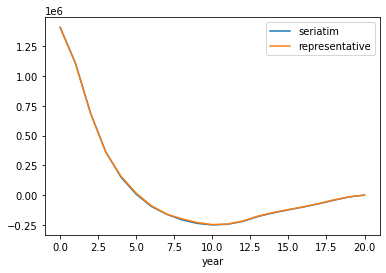

In [14]:
cf_comp[['seriatim', 'representative']].plot()

The scatter plot below plots the total cashflows of the portfolio calculated from the seriatim policies and from the scaled representative model points.

<AxesSubplot:xlabel='seriatim', ylabel='representative'>

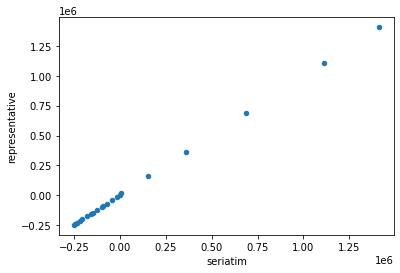

In [15]:
cf_comp.plot(x='seriatim', y='representative', kind='scatter')

The scatter plot below plots annual cashflows of the clusters. The x value of a dot represents a certain year's total net cashflow of seriatim policies in a certain cluster, an the y vlaue represents the same year's net cashflow of a cluster calculated using the scaled representative model point.

<AxesSubplot:xlabel='seriatim', ylabel='representative'>

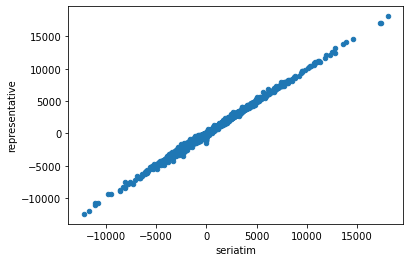

In [16]:
mult_rep_cfs_stacked = mult_rep_cfs.stack()
mult_rep_cfs_stacked.index.names = ['cluster_id', 'year']
mult_rep_cfs_stacked

agg_cfs_by_cluster_stacked = agg_cfs_by_cluster[agg_cfs_by_cluster.columns[1:]].stack()
agg_cfs_by_cluster_stacked.index.names = ['cluster_id', 'year']
agg_cfs_by_cluster_stacked

cf_comp_by_cluster = pd.DataFrame({'seriatim': mult_rep_cfs_stacked, 'representative':agg_cfs_by_cluster_stacked})
cf_comp_by_cluster.plot(x='seriatim', y='representative', kind='scatter')

## Testing the model points with lapse stress 

Using the model points and the numbers of policies in the clusters, cashflows under a lpase stress scenario are calculated and compared against the seriatim cashflows. 

In [17]:
cfs_lapse50 = pd.read_excel('cashflows_seriatim_10K_lapse50.xlsx', index_col=0)

In [18]:
def get_cfs_by_cluster(cfs):
    
    rep_cfs = pd.merge(rep_ids, cfs.reset_index(), how='left', on='policy_id')
    rep_cfs.index.name = 'cluster_id'
    cfs_with_cluster_id = cfs.copy()
    cfs_with_cluster_id.insert(0, 'policy_count', 1)
    cfs_with_cluster_id.insert(0, 'cluster_id', kmeans.labels_)
    cfs_with_cluster_id= cfs_with_cluster_id.set_index('cluster_id')
    agg_cfs_by_cluster = cfs_with_cluster_id.groupby(cfs_with_cluster_id.index).agg(sum)
    mult_rep_cfs = rep_cfs[rep_cfs.columns[1:]].mul(agg_cfs_by_cluster['policy_count'], axis=0)
    return agg_cfs_by_cluster, mult_rep_cfs
    

In [19]:
agg_cfs_by_cluster_lapse50, mult_rep_cfs_lapse50 = get_cfs_by_cluster(cfs_lapse50)

In [20]:
def get_cf_comp(agg_cfs_by_cluster, mult_rep_cfs):
    cf_comp = pd.DataFrame({'seriatim': agg_cfs_by_cluster.sum().iloc[1:], 'representative': mult_rep_cfs.sum()})
    cf_comp['ratio'] = cf_comp['representative'] / cf_comp['seriatim']
    cf_comp.index.name = 'year'
    return cf_comp

cf_comp_lapse50 = get_cf_comp(agg_cfs_by_cluster_lapse50, mult_rep_cfs_lapse50)

cf_comp_lapse50

,seriatim,representative,ratio
year,,,
0,1.351729e+06,1.347313e+06,0.996733
1,9.638136e+05,9.601629e+05,0.996212
2,5.328851e+05,5.307858e+05,0.996060
3,2.298320e+05,2.286642e+05,0.994919
4,4.848208e+04,5.670938e+04,1.169698
5,-6.499799e+04,-5.657670e+04,0.870438
6,-1.409627e+05,-1.351473e+05,0.958746
7,-1.823877e+05,-1.803155e+05,0.988638
8,-2.090425e+05,-2.022727e+05,0.967615


In [21]:
def comp_npv(cf_comp):
    return sum(1 / 1.03 ** cf_comp.index * cf_comp['representative']) / sum(1 / 1.03 ** cf_comp.index * cf_comp['seriatim'])

comp_npv(cf_comp_lapse50)

1.017695269180519

<AxesSubplot:xlabel='year'>

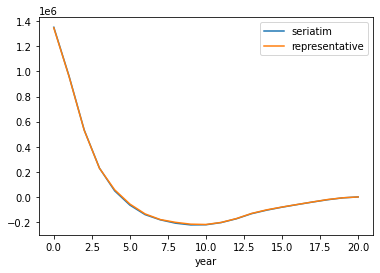

In [22]:
cf_comp_lapse50[['seriatim', 'representative']].plot()

<AxesSubplot:xlabel='seriatim', ylabel='representative'>

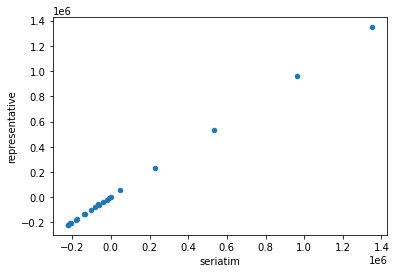

In [23]:
cf_comp_lapse50.plot(x='seriatim', y='representative', kind='scatter')

In [24]:
def get_cf_comp_by_cluster(agg_cfs_by_cluster, mult_rep_cfs):
    mult_rep_cfs_stacked = mult_rep_cfs.stack()
    mult_rep_cfs_stacked.index.names = ['cluster_id', 'year']
    mult_rep_cfs_stacked

    agg_cfs_by_cluster_stacked = agg_cfs_by_cluster[agg_cfs_by_cluster.columns[1:]].stack()
    agg_cfs_by_cluster_stacked.index.names = ['cluster_id', 'year']
    agg_cfs_by_cluster_stacked

    return pd.DataFrame({'seriatim': mult_rep_cfs_stacked, 'representative':agg_cfs_by_cluster_stacked})

<AxesSubplot:xlabel='seriatim', ylabel='representative'>

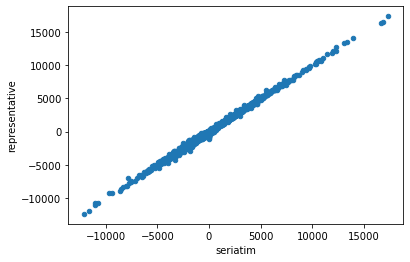

In [25]:
get_cf_comp_by_cluster(agg_cfs_by_cluster_lapse50, mult_rep_cfs_lapse50).plot(x='seriatim', y='representative', kind='scatter')

## Testing the model points with mortality stress

In [26]:
cfs_mort15 = pd.read_excel('cashflows_seriatim_10K_mort15.xlsx', index_col=0)
agg_cfs_by_cluster_mort15, mult_rep_cfs_mort15 = get_cfs_by_cluster(cfs_mort15)
cf_comp_mort15 = get_cf_comp(agg_cfs_by_cluster_mort15, mult_rep_cfs_mort15)
cf_comp_mort15

,seriatim,representative,ratio
year,,,
0,367262.190647,376223.171985,1.024399
1,163014.911398,180488.113918,1.107188
2,-158091.685274,-151816.168925,0.960305
3,-395006.292558,-385011.526166,0.974697
4,-514752.399204,-490901.470651,0.953665
5,-572824.166984,-558882.005664,0.975661
6,-597150.783944,-593489.595085,0.993869
7,-589633.519365,-592076.132511,1.004143
8,-570106.393577,-557314.843156,0.977563


In [27]:
def comp_npv(cf_comp):
    return sum(1 / 1.03 ** cf_comp.index * cf_comp['representative']) / sum(1 / 1.03 ** cf_comp.index * cf_comp['seriatim'])

comp_npv(cf_comp_mort15)

0.9756653105940207

<AxesSubplot:xlabel='year'>

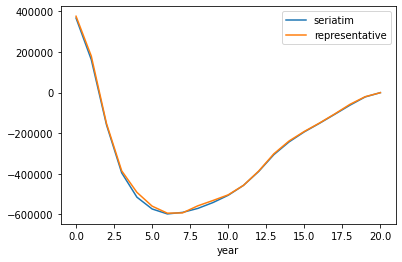

In [28]:
cf_comp_mort15[['seriatim', 'representative']].plot()

<AxesSubplot:xlabel='seriatim', ylabel='representative'>

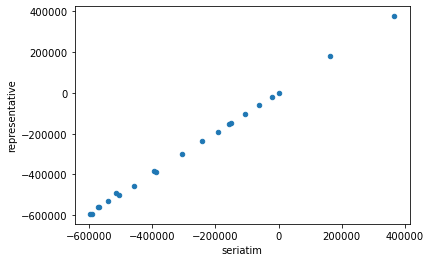

In [29]:
cf_comp_mort15.plot(x='seriatim', y='representative', kind='scatter')

<AxesSubplot:xlabel='seriatim', ylabel='representative'>

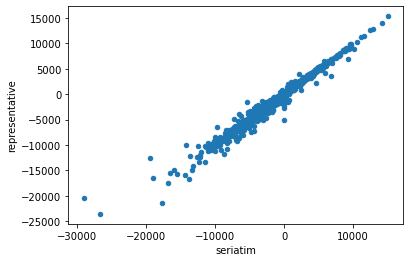

In [30]:
get_cf_comp_by_cluster(agg_cfs_by_cluster_mort15, mult_rep_cfs_mort15).plot(x='seriatim', y='representative', kind='scatter')